In [1]:
import tensorflow as tf

import numpy as np

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

#data = pd.read_csv('bitcoin.csv')
data = pd.read_csv('https://raw.githubusercontent.com/ikwak2/hj19_timeseries/main/btc/bitcoin2000.csv?token=ATB7FV4BSDYDQWJVQOJY2C3BMRBN6')

In [3]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad


def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [4]:
data

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timeUTC
0,1576144800,7219.93,7149.15,7170.18,1536.79,11041994.81,7166.14,direct,NaN,2019-12-12 19:00:00
1,1576148400,7208.36,7166.03,7166.14,785.11,5654607.43,7199.79,direct,NaN,2019-12-12 20:00:00
2,1576152000,7222.43,7194.87,7199.79,672.46,4855213.22,7199.97,direct,NaN,2019-12-12 21:00:00
3,1576155600,7211.80,7187.29,7199.97,807.61,5821087.81,7201.38,direct,NaN,2019-12-12 22:00:00
4,1576159200,7229.22,7152.84,7201.38,1606.06,11537799.57,7173.50,direct,NaN,2019-12-12 23:00:00
...,...,...,...,...,...,...,...,...,...,...
10000,1612144800,33847.46,33257.39,33450.01,2066.49,69445570.35,33675.45,direct,NaN,2021-02-01 11:00:00
10001,1612148400,33779.76,33505.50,33675.45,1173.82,39473368.04,33590.20,direct,NaN,2021-02-01 12:00:00
10002,1612152000,33945.41,33404.87,33590.20,1430.06,48159838.72,33576.82,direct,NaN,2021-02-01 13:00:00
10003,1612155600,33907.89,33467.87,33576.82,1198.20,40319458.23,33803.02,direct,NaN,2021-02-01 14:00:00


In [5]:
'''
from sklearn.preprocessing import MinMaxScaler
values = data[['close','high','low','open','volumefrom','volumeto']].values.reshape(-1,6)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values) '''

"\nfrom sklearn.preprocessing import MinMaxScaler\nvalues = data[['close','high','low','open','volumefrom','volumeto']].values.reshape(-1,6)\nvalues = values.astype('float32')\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaled = scaler.fit_transform(values) "

In [6]:
from sklearn.preprocessing import MinMaxScaler
values = data[['close','high','low','open','volumefrom','volumeto']].values.reshape(-1,6)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled=scaler.fit_transform(values)
#scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))
#scaled = (values - np.mean(values))/np.std(values) 

In [7]:
np.max(values)

7859574300.0

In [8]:
np.min(values)

161.86

In [9]:
np.max(values)-np.min(values)

7859574300.0

In [10]:
scaled

array([[7.8535259e-02, 6.9533341e-02, 8.6421244e-02, 7.8643724e-02,
        5.8386968e-03, 1.2568906e-03],
       [7.9438612e-02, 6.9223486e-02, 8.6877085e-02, 7.8535259e-02,
        2.6466567e-03, 5.7133357e-04],
       [7.9443455e-02, 6.9600292e-02, 8.7655909e-02, 7.9438612e-02,
        2.1682840e-03, 4.6960887e-04],
       ...,
       [7.8754401e-01, 7.8523761e-01, 7.9544908e-01, 7.8790319e-01,
        5.3854641e-03, 5.9802183e-03],
       [7.9361647e-01, 7.8423285e-01, 7.9715037e-01, 7.8754401e-01,
        4.4008605e-03, 4.9825124e-03],
       [7.9614097e-01, 7.8537852e-01, 8.0448914e-01, 7.9361647e-01,
        1.7305929e-03, 2.3062201e-03]], dtype=float32)

In [11]:

train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:]
print(len(train),len(val), len(test))

8004 1000 1001


In [12]:
def create_dataset_multistep(dataset, look_back=1,predict=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-predict):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i+ look_back-1: i+ look_back+predict-1, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [13]:
look_back = 168
predict=24
trainX, trainY = create_dataset_multistep(train, look_back,predict)
valX, valY = create_dataset_multistep(val, look_back,predict)
testX, testY = create_dataset_multistep(test, look_back,predict)

7812
808
809


In [14]:
testX

array([[[0.5081322 , 0.4972723 , 0.50418204, 0.49842197, 0.01987398,
         0.01396313],
        [0.50627834, 0.49758053, 0.51247734, 0.5081322 , 0.01269652,
         0.00910186],
        [0.5095518 , 0.50080806, 0.5140396 , 0.50627834, 0.01281198,
         0.00923004],
        ...,
        [0.60594934, 0.5949154 , 0.61132294, 0.602308  , 0.00614555,
         0.00532355],
        [0.6126975 , 0.6016524 , 0.61389863, 0.60594934, 0.00730702,
         0.00630235],
        [0.61675006, 0.611603  , 0.6242047 , 0.6126975 , 0.01305175,
         0.01107979]],

       [[0.50627834, 0.49758053, 0.51247734, 0.5081322 , 0.01269652,
         0.00910186],
        [0.5095518 , 0.50080806, 0.5140396 , 0.50627834, 0.01281198,
         0.00923004],
        [0.4960037 , 0.49831617, 0.5053867 , 0.5095518 , 0.01790486,
         0.01260215],
        ...,
        [0.6126975 , 0.6016524 , 0.61389863, 0.60594934, 0.00730702,
         0.00630235],
        [0.61675006, 0.611603  , 0.6242047 , 0.6126975 , 0.013

In [15]:

print(trainX.shape)
print(trainY.shape)

(7812, 168, 6)
(7812, 24)


In [16]:
SMALL_SIZE = 20
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

CNN-LSTM

In [17]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,6))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Dropout(0.5)(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(100)(in1)
in1=Dense(100)(in1)
in1=Dropout(0.5)(in1)
out=Dense(24)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_cnnlstm_multistep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [18]:
model.load_weights("/content/btc_cnnlstm_multistep.hdf5")

1.4931027
-0.40120554
1.8943082
(1, 168, 6)


<Figure size 432x1440 with 0 Axes>

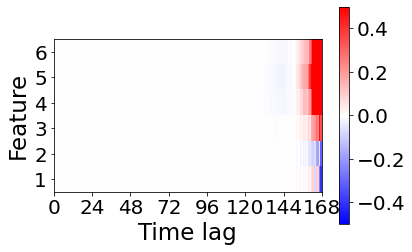

In [19]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[5], model)

print(np.max(grad_weight))
print(np.min(grad_weight))
print(np.max(grad_weight)-np.min(grad_weight))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(168,6)
a=a.transpose()
#print(a)
fig, ax = plt.subplots(1,1)

y_label_list = [1,2,3,4,5,6]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([8,24,40,56,72,88])

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
ax.set_xlabel('Time lag')
ax.set_ylabel('Feature')

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=-0.5, vmax=0.5, cmap="bwr", interpolation='nearest')
plt.colorbar()

plt.savefig('btc_feature importance_cnn-lstm.png')

LSTM-CNN

In [20]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,6))

in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor1')

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Flatten()(in1)
in1=Dense(100, activation='relu')(in1)

in1=Dropout(0.5)(in1)
out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_lstmcnn_mulstep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


In [21]:
model.load_weights("/content/btc_lstmcnn_mulstep.hdf5")

0.8559743
-0.15432778
1.0103021
(1, 168, 6)


<Figure size 432x1440 with 0 Axes>

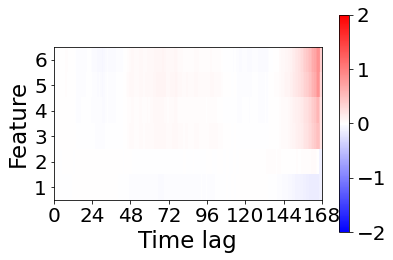

In [22]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[5], model)

print(np.max(grad_weight))
print(np.min(grad_weight))
print(np.max(grad_weight)-np.min(grad_weight))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(168,6)
a=a.transpose()
#print(a)
fig, ax = plt.subplots(1,1)

y_label_list = [1,2,3,4,5,6]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([8,24,40,56,72,88])

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
ax.set_xlabel('Time lag')
ax.set_ylabel('Feature')

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=-2, vmax=2, cmap="bwr", interpolation='nearest')
plt.colorbar()

plt.savefig('btc_feature importance_lstm-cnn.png')

LSTM-resCNN




In [23]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,6))

in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor1')

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor')


in1=Flatten()(in1)
in1=Dense(100, activation='relu')(in1)
in1=Dropout(0.5)(in1)

out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_lstmrescnn_mulstep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [24]:
model.load_weights("/content/btc_lstmrescnn_mulstep.hdf5")

1.4442997
-0.32770747
1.7720072
(1, 168, 6)


<Figure size 432x1440 with 0 Axes>

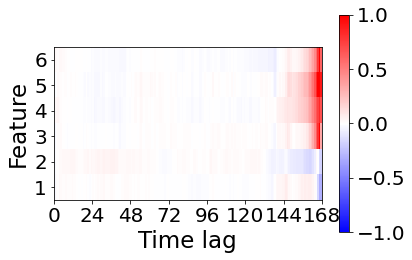

In [25]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[5], model)

print(np.max(grad_weight))
print(np.min(grad_weight))
print(np.max(grad_weight)-np.min(grad_weight))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(168,6)
a=a.transpose()
#print(a)
fig, ax = plt.subplots(1,1)

y_label_list = [1,2,3,4,5,6]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([8,24,40,56,72,88])

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
ax.set_xlabel('Time lag')
ax.set_ylabel('Feature')

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=-1, vmax=1, cmap="bwr", interpolation='nearest')
plt.colorbar()

plt.savefig('btc_feature importance_reslstm-cnn.png')